In [1]:
import matplotlib.pyplot as plt
import urllib, json
import tensorflow as tf
import numpy as np
import pandas
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
import pickle

2024-11-21 05:16:23.215229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 05:16:23.313592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 05:16:23.314276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 05:16:23.453531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 05:16:25.030168: W tensorflow/compiler/tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (10, 10)
plt.rc('font', size=8)

Num GPUs Available:  0


2024-11-21 05:16:51.710120: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), tokenizer.tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

In [4]:
def updateData():
    res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
    data = json.loads(res.read())
    exemplos_treinamento = data['data']
    qtd_pos = data['qtd_pos']
    qtd_neg = data['qtd_neg']
    
    pickle.dump(exemplos_treinamento, file = open("exemplos.pickle", "wb"))
    pickle.dump(qtd_pos, file = open("qtd_pos.pickle", "wb"))
    pickle.dump(qtd_neg, file = open("qtd_neg.pickle", "wb"))
    

In [5]:
exemplos_treinamento = pickle.load(open("exemplos.pickle", "rb"))
qtd_pos = pickle.load(open("qtd_pos.pickle", "rb"))
qtd_neg = pickle.load(open("qtd_neg.pickle", "rb"))

In [6]:
from collections import OrderedDict

histograma = []

for exemplo in exemplos_treinamento:
    txtVaga = exemplo['txtVaga']
    tokens = converteTextoParaTokens(txtVaga)
    histograma += tokens

frequencia_tokens = Counter(histograma)
frequencia_tokens = OrderedDict(frequencia_tokens.most_common())
frequencia_tokens = {k: c for k, c in frequencia_tokens.items() if c > 5}
print(len(frequencia_tokens))
df = pandas.DataFrame.from_dict(frequencia_tokens, orient='index')
#df.plot(kind='bar')

1511


In [7]:
sentences = []
pos = []
maxlen = 46

for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [8]:
UNKNOWN_IDX = len(frequencia_tokens) - 1
word_list = ['<pad>'] + list(frequencia_tokens.keys()) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) or UNKNOWN_IDX for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/50


2024-11-21 05:17:32.587477: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142536704 exceeds 10% of free system memory.
2024-11-21 05:17:32.604221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142536704 exceeds 10% of free system memory.


 1/40 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - auc: 0.6359 - fn: 2.0000 - fp: 280.0000 - loss: 0.5712

2024-11-21 05:17:32.841859: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142536704 exceeds 10% of free system memory.
2024-11-21 05:17:32.870854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142536704 exceeds 10% of free system memory.
2024-11-21 05:17:32.911274: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142536704 exceeds 10% of free system memory.


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - auc: 0.7814 - fn: 42.3415 - fp: 2382.0000 - loss: 0.5340
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - auc: 0.9648 - fn: 10.1220 - fp: 1241.6342 - loss: 0.2530
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - auc: 0.9830 - fn: 2.7317 - fp: 758.8781 - loss: 0.1427
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - auc: 0.9855 - fn: 3.5366 - fp: 784.4390 - loss: 0.1404
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - auc: 0.9929 - fn: 2.6098 - fp: 481.6829 - loss: 0.0898
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 523ms/step - auc: 0.9946 - fn: 0.9756 - fp: 345.7805 - loss: 0.0668
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - auc: 0.9914 - fn: 1.2683 - fp: 475.1951 - loss: 0.0910
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - auc: 0.9955 - fn: 1.2439 - fp: 303.6342 - loss: 0.0637
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - auc: 0.9950 - fn: 0.6829 - fp: 341.5854 - loss: 0.0646
Epoch 10/50
40/40

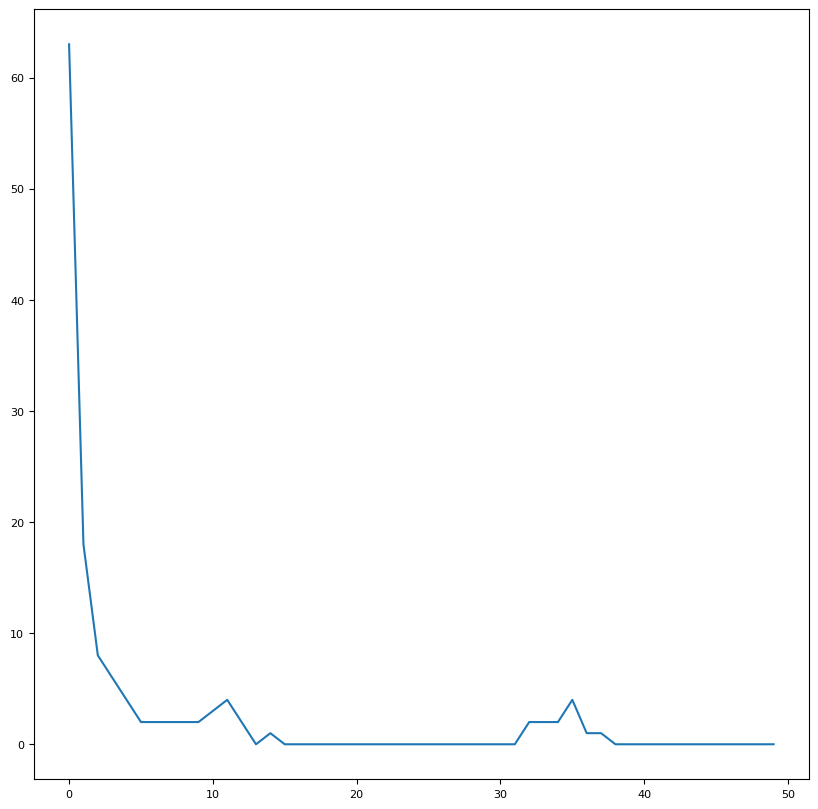

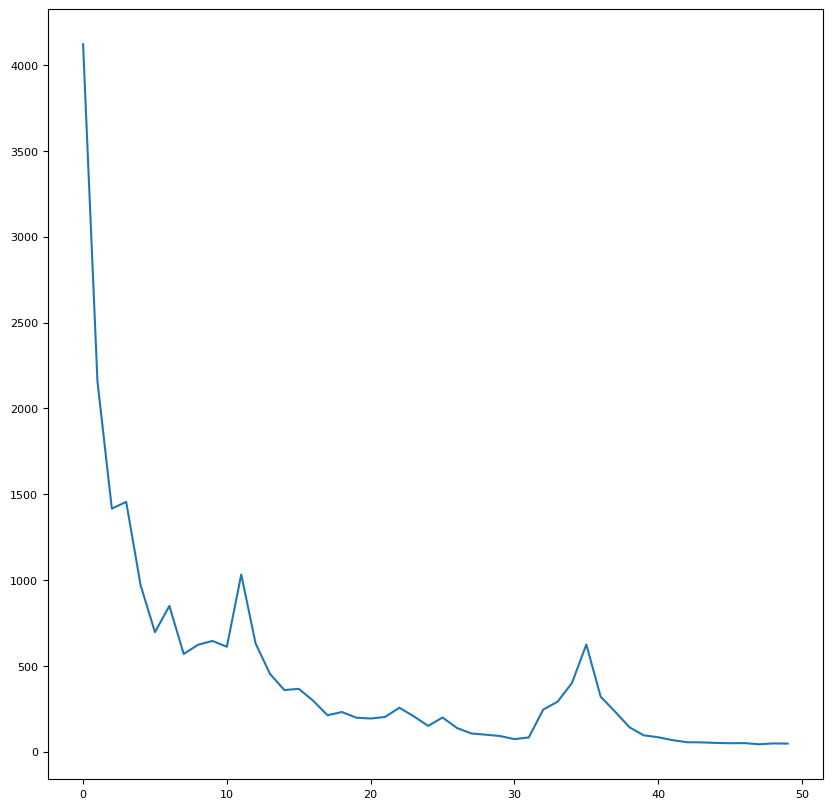

In [9]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 512
epochs = 40

optimizer = Adam()

loss_function = BinaryCrossentropy()

additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.AUC(name='auc')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 2.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

plt.figure()
plt.plot(history.history['fp'])
plt.show()

In [11]:
model.save("model.keras")